## Spam detection

We use the famous spam/ham data set of labeled text messages

In [ ]:
!mkdir data
!wget -O data/bikes.csv https://raw.githubusercontent.com/MJafarMashhadi/MachineLearningWorkshop/master/data/sms.tsv

In [ ]:
import re, string
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt 
%matplotlib inline

sms = pd.read_csv('data/sms.tsv', sep='\t', header=None, names=['label', 'text'])
sms['label'] = sms['label'].astype('category')
sms

In [ ]:
sms.groupby('label').count()

In [23]:
print(('\n'*3).join(sms.loc[sms['label'] == 'spam'].loc[[11, 5, 123, 147, 5566]].text.tolist()))

SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info


FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv


Todays Voda numbers ending 7548 are selected to receive a $350 award. If you have a match please call 08712300220 quoting claim code 4041 standard rates app


FreeMsg Why haven't you replied to my text? I'm Randy, sexy, female and live local. Luv to hear from u. Netcollex Ltd 08700621170150p per msg reply Stop to end


REMINDER FROM O2: To get 2.50 pounds free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode


Let's clean the texts up first:
* Make everything lowercase
* Remove punctuations
* Clean up white spaces
* Remove stop words **(\*)**
* Stem the words **(\*)**

In [22]:
for w in ['cats', 'cat', 'graduation', 'behavioural']:
    print(f'{w:15} --stemmer--> {stemmer.stem(w)}')

cats            --stemmer--> cat
cat             --stemmer--> cat
graduation      --stemmer--> graduat
behavioural     --stemmer--> behaviour


In [24]:
ENGLISH_STOP_WORDS

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [25]:
stemmer = SnowballStemmer(language='english')
def clean_text(text):
    """
    text: str, returns: str
    """
    text = text.lower()
    text = re.sub('\s+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([stemmer.stem(w) for w in text.split() if w not in ENGLISH_STOP_WORDS])
    return text

sms['text'] = sms.text.apply(clean_text)

In [26]:
print(('\n'*3).join(sms.loc[sms['label'] == 'spam'].loc[[11, 5, 123, 147, 5566]].text.tolist()))

chanc win cash 100 20000 pound txt csh11 send 87575 cost 150pday 6day 16 tsandc appli repli hl 4 info


freemsg hey darl 3 week word id like fun tb ok xxx std chgs send £150 rcv


today voda number end 7548 select receiv 350 award match 08712300220 quot claim code 4041 standard rate app


freemsg havent repli text im randi sexi femal live local luv hear u netcollex 08700621170150p msg repli stop end


remind o2 250 pound free credit detail great offer pls repli 2 text valid hous postcod


### Vectorization


In [39]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


def build_tfidf(documents):
    vectorizer = TfidfVectorizer(min_df=2)  
    vectorizer.fit(documents)
    return vectorizer

vectorizer = build_tfidf(sms['text'])
print('Vocabulary size =', len(vectorizer.vocabulary_))

Vocabulary size = 3540


In [35]:
transformed = vectorizer.transform([clean_text("""FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv""")])[0]

In [41]:
transformed[transformed.nonzero()]

matrix([[0.25335005, 0.23448613, 0.195195  , 0.33456402, 0.30563502,
         0.18039781, 0.35588369, 0.16777287, 0.17317091, 0.2558058 ,
         0.20517943, 0.25709008, 0.29468506, 0.31494808, 0.24574073]])

(0.9, 1)

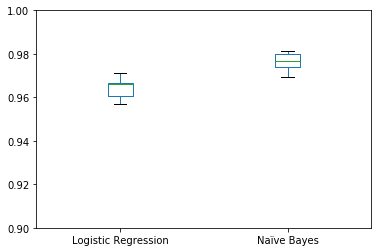

In [46]:
scores = {name: [] for name in ('Logistic Regression', 'Naïve Bayes')}

for split_seed in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        sms['text'],
        sms['label'],
        test_size=0.2,
        random_state=split_seed,
        stratify=sms['label']
    )

    vectorizer = build_tfidf(X_train)
    X_train = vectorizer.transform(X_train)
    X_test = vectorizer.transform(X_test)

    nb = BernoulliNB().fit(X_train, y_train)
    lr = LogisticRegression(solver='liblinear', random_state=0).fit(X_train, y_train)

    scores['Logistic Regression'].append(lr.score(X_test, y_test))
    scores['Naïve Bayes'].append(nb.score(X_test, y_test))

pd.DataFrame(scores).plot(kind='box');
plt.ylim([0.9,1])